In [28]:
%cd /home/chickencurry/emb-ml-challenge

/home/chickencurry/emb-ml-challenge


In [29]:
import torch
from utils.taylor_pruning import TinyYoloV2WithTaylorRanking, get_channels_to_prune_per_layer, prune_state_dict 
from utils.dataloader import VOCDataLoaderPerson
from utils.loss import YoloLoss
from utils.train_eval import validate
from utils.tinyyolov2 import TinyYoloV2Pruned, TinyYoloV2
import copy
import numpy as np
from typing import List, Dict
from utils.metrics import get_num_params

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [31]:
train_loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
val_loader = VOCDataLoaderPerson(train=False, batch_size=1)

In [32]:
load_path = './runs/voc_person_only.pt'

In [33]:
net = TinyYoloV2WithTaylorRanking(device, num_classes=1)
net.load_state_dict(torch.load(load_path), strict=False)
baseline_num_params = get_num_params(net)
print(baseline_num_params)
criterion = YoloLoss(anchors=net.anchors)

15764398


100%|██████████| 350/350 [00:21<00:00, 16.01it/s]


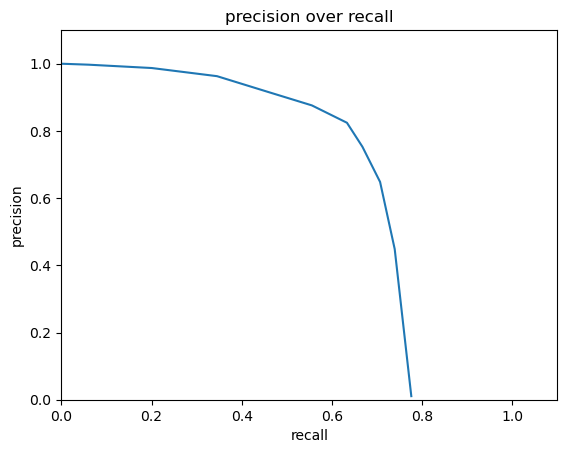

0.6546829871616197

In [34]:
validate(net, device, val_loader, roc=True)

In [35]:
channels_to_prune_per_layer = get_channels_to_prune_per_layer(net, criterion, train_loader, device, 650)
state_dict = torch.load(load_path)
state_dict = prune_state_dict(state_dict, channels_to_prune_per_layer)
net = TinyYoloV2Pruned(num_classes=1)
net.load_state_dict(state_dict, strict=False)


100%|██████████| 17/17 [02:13<00:00,  7.82s/it]

[0, 0, 0, 0, 7, 36, 203, 404, 0]


<All keys matched successfully>

In [36]:
percentage_of_params = get_num_params(net) / baseline_num_params
print(percentage_of_params)

0.6072258515675638


100%|██████████| 350/350 [00:22<00:00, 15.62it/s]


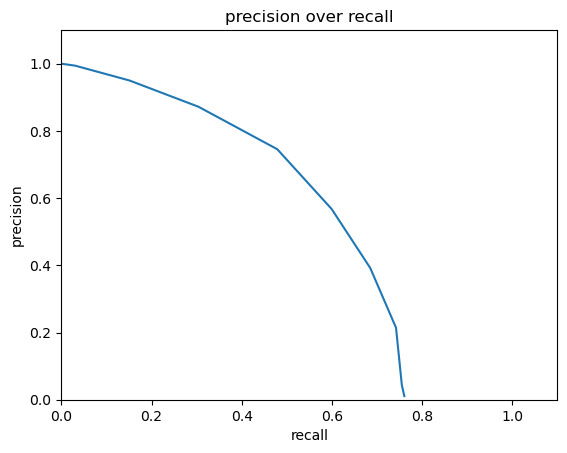

0.5103357293933516

In [37]:
validate(net, device, val_loader, roc=True)

In [38]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float, ignored_n: List[int]) -> Dict:
    state_dict = copy.deepcopy(state_dict)

    mask_dict = {}
    
    for key, value in state_dict.items():
        n = key.split(".")[0][-1]  
        n = int(n) if n.isdigit() else None

        if n is None or n in ignored_n:
            continue
        
        if "conv" in key and "weight" in key:
            norms = value.flatten(1).norm(p=1, dim=1)
            percentile = np.percentile(norms, prune_ratio * 100)
            mask = (norms >= percentile)
            state_dict[key] = value * mask[:, None, None, None]
            mask_dict[n] = mask

    for n in range(1, 9):
        if n in ignored_n:
            continue
        
        keys = [f"bn{n}.weight", f"bn{n}.bias", f"bn{n}.running_mean", f"bn{n}.running_var"]
        for key in keys:
            state_dict[key] = state_dict[key] * mask_dict[n]
    
    return state_dict

def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    
    indices_dict = {}
    
    for key, value in state_dict.items():
        if "conv" in key and "weight" in key:

            n = key.split(".")[0][-1]  
            n = int(n) if n.isdigit() else None

            if n is not None and n-1 in indices_dict:
                value = value[:, indices_dict[n-1], :, :]
                
            summed = value.flatten(1).abs().sum(1)
            indices = summed.nonzero().flatten()
            value = value[indices, :, :, :]
            state_dict[key] = value

            indices_dict[n] = indices
        
        elif "bn" in key and "num_batches_tracked" not in key:
            indices = value.nonzero().flatten()
            value = value[indices]
            state_dict[key] = value
    
    return state_dict

In [41]:
ratio = 0.22
state_dict = torch.load('./runs/voc_person_only.pt')
state_dict = l1_structured_pruning(state_dict, ratio, [9])
state_dict = densify_state_dict(state_dict)
net.load_state_dict(state_dict)
percentage_of_params = get_num_params(net) / baseline_num_params
print(percentage_of_params)

0.6076076612630562


100%|██████████| 350/350 [00:20<00:00, 17.00it/s]


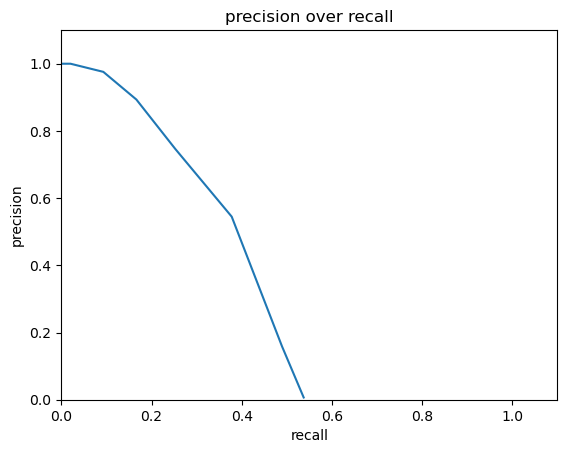

0.3045540016879731

In [42]:
validate(net, device, val_loader, roc=True)